In [1]:
from oneatlas import OneAtlasClient
import json
import geopandas as gpd

# Process overview
- Convert input aoi layer into geojson polygons
- Search API for available images and convert available images footprints to geodataframe
- spatial join the footprints to the aoi gdf
- use the aoi - images gdf to plot image quicklooks
- also convert them to the image windows used to place an order
- place an order for a window around the AOI - if just a 2 km by 2 km or similar this costs magnitudes less than ordering full image

In [2]:
# Need to look at jpeg2000 output, options to project to BNG etc before order

In [3]:
# function to convert polygon gdf to bounding box list
aoi_gdf = gpd.read_file("inputs/test_quarries.shp")

In [4]:
aoi_gdf["geometry"] = aoi_gdf.buffer(1000)

In [5]:
def aoi_gdf_to_search_geojson(aoi_gdf, uid_column=None):
    if uid_column is None:
        uid_column = "id"
        aoi_gdf[uid_column] = aoi_gdf.index

    else:
        if not aoi_gdf[uid_column].is_unique:
            raise ValueError(
                f"Values in '{uid_column}' are not unique. Consider using default uid_column=None to add uids."
            )
    print(
        f"uid_column '{uid_column}' values {', '.join(str(i) for i in aoi_gdf[uid_column].tolist())}"
    )
    json_str = aoi_gdf[[uid_column, "geometry"]].to_crs(epsg=4326).to_json(drop_id=True)
    return json.loads(json_str), aoi_gdf[uid_column].tolist()

In [6]:
search_geojson, id_vals = aoi_gdf_to_search_geojson(aoi_gdf)

uid_column 'id' values 0, 1, 2, 3


In [7]:
def get_feature_by_id(geojson, id_vals, search_id):
    if search_id not in id_vals:
        raise ValueError(f"id {search_id} not in list of id values")
    for feature in geojson["features"]:
        if feature["properties"]["id"] == search_id:
            return feature
    return None

In [8]:
# search_test = search_geojson["features"][0]["geometry"]
SEARCH_ID = 0
search_feature = get_feature_by_id(search_geojson, id_vals, SEARCH_ID)

In [9]:
# Read local config.json to get api key
with open("config.json", "r") as file:
    config = json.load(file)
api_key = config["api_key"]

client = OneAtlasClient(api_key=api_key)

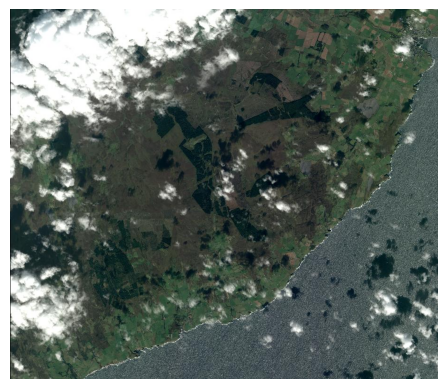

In [10]:
results = client.search(
    {
        "cloudCover": "[0,30]",
        "incidenceAngle": "[0,40]",
        "processingLevel": "SENSOR",
        "relation": "contains",
        "geometry": search_feature["geometry"],
        "constellation": "PHR",
    }
)
client.extract_results(results)

Image ID: 480c726d-668f-4f21-af5d-0caa69e23b77
Acquisition Date: 2022-06-03T11:26:18.055Z
Cloud Cover: 3.3%


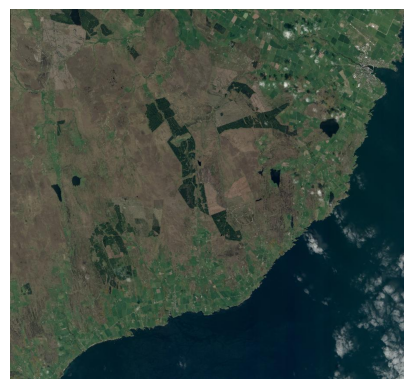

In [18]:
client.next_result()

In [ ]:
order_body = {
    "kind": "order.product",
    "products": [
        {
            "productType": "bundle",
            "radiometricProcessing": "REFLECTANCE",
            "imageFormat": "image/jp2",
            "crsCode": "urn:ogc:def:crs:EPSG::4326",
            "id": image_id,
            "aoi": bbox_order,
        }
    ],
}
price = client.get_price(order_body)

In [ ]:
order_body = {
    "kind": "order.product",
    "products": [
        {
            "productType": "bundle",
            "radiometricProcessing": "REFLECTANCE",
            "imageFormat": "image/jp2",
            "crsCode": "urn:ogc:def:crs:EPSG::4326",
            "id": "a62ca420-399f-4a7f-8623-eca3bf0d397b",
            "aoi": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-3.3416796390244294, 58.2848266233006],
                        [-3.3416796390244294, 58.32134905375606],
                        [-3.272209519926957, 58.32134905375606],
                        [-3.272209519926957, 58.2848266233006],
                        [-3.3416796390244294, 58.2848266233006],
                    ]
                ],
            },
        }
    ],
}
client.get_price(order_body)["price"]

In [ ]:
client.create_order(order_body)

In [ ]:
orders = client.list_orders(kind="order.data.product", status="delivered")

In [ ]:
order = orders["items"][0]
client.download_order_to_file(order, "outputs/order.zip")